In [31]:
import datetime
import gc
import joblib
import json
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
import os
import scipy.stats
import seaborn as sns
import sys
sys.path.append("../")
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
from imblearn.over_sampling import SMOTE
from itertools import repeat
from lightgbm import LGBMClassifier, log_evaluation
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer, mean_squared_error
from tqdm import tqdm

In [25]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
from colorama import Fore, Back, Style
plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [3]:
from utils.common import (
    sigmoid, pad_column_name, reverse_sigmoid
)
from utils.constants import *
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)

In [4]:
%load_ext autoreload
%autoreload

### Read Data

In [5]:
%%time
train_agg = read_file(f"../{PROCESSED_DATA_PATH}/v5/final_train_agg.parquet")

Shape of data: (458913, 4241)
CPU times: user 14.6 s, sys: 16 s, total: 30.5 s
Wall time: 17.3 s


In [98]:
%%time
test_agg = read_file(f"../{PROCESSED_DATA_PATH}/v5/final_test_agg.parquet")

Shape of data: (924621, 4240)
CPU times: user 27.6 s, sys: 34.6 s, total: 1min 2s
Wall time: 1min 13s


In [6]:
labels = read_file(f"../{RAW_DATA_PATH}/train_labels.csv")
target = labels["target"].values

Shape of data: (458913, 2)


In [99]:
%%time
# train_agg = train_agg.drop(columns=NON_FEATURE_COLUMNS + ["target"], errors="ignore")
test_agg = test_agg.drop(columns=NON_FEATURE_COLUMNS, errors="ignore")
gc.collect()

CPU times: user 965 ms, sys: 6.65 s, total: 7.62 s
Wall time: 24.2 s


18

In [8]:
cat_columns = get_cols(train_agg, CATEGORY_COLUMNS)
cat_features = list(set(cat_columns).intersection(train_agg.columns))
print(cat_features)

['D_64_third_last', 'D_117_second_last', 'D_116_last', 'D_120_third_last', 'D_120_last', 'D_64_last', 'D_92_first', 'D_63_first', 'B_38_second_last', 'B_30_last', 'D_116_first', 'D_126_third_last', 'D_117_third_last', 'D_117_last', 'D_92_second_last', 'D_117_first', 'D_116_second_last', 'D_64_second_last', 'B_38_first', 'D_116_third_last', 'B_30_second_last', 'D_114_third_last', 'D_63_second_last', 'B_38_last', 'D_92_last', 'D_68_second_last', 'D_126_first', 'D_126_last', 'D_68_last', 'D_114_last', 'B_38_third_last', 'D_126_second_last', 'D_92_third_last', 'D_63_third_last', 'D_68_third_last', 'D_114_second_last', 'D_120_first', 'D_63_last', 'D_114_first', 'D_68_first', 'B_30_first', 'D_120_second_last', 'D_64_first', 'B_30_third_last']


In [9]:
train_agg.shape, target.shape

((458913, 4240), (458913,))

In [100]:
test_agg.shape

(924621, 4240)

### Drop more-than-30%-missing columns

In [20]:
m = train_agg.isnull().sum()
missing_cols = m[m > int(train_agg.shape[0] * 0.3)].index.tolist()

In [21]:
train_agg = train_agg.drop(columns=missing_cols, errors="ignore")
train_agg.shape

(458913, 2852)

In [101]:
test_agg = test_agg.drop(columns=missing_cols, errors="ignore")
test_agg.shape

(924621, 2852)

### Clip all values to the range of -1000 to 1000

In [33]:
c = train_agg.max()

In [38]:
to_clip_max = c[c > 1e3].index.tolist()

In [39]:
d = train_agg.min()

In [40]:
to_clip_min = c[c < -1e3].index.tolist()

In [41]:
len(to_clip_max), len(to_clip_min)

(247, 0)

In [42]:
for col in tqdm(to_clip_max):
    train_agg[col] = np.clip(train_agg[col], -1e3, 1e3)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 247/247 [08:30<00:00,  2.07s/it]


In [102]:
for col in tqdm(to_clip_max):
    test_agg[col] = np.clip(test_agg[col], -1e3, 1e3)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 247/247 [24:34<00:00,  5.97s/it]


In [107]:
e = test_agg.max()

In [110]:
to_clip_max_test = e[e > 1e3].index.tolist()

In [112]:
for col in tqdm(to_clip_max_test):
    test_agg[col] = np.clip(test_agg[col], -1e3, 1e3)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [02:00<00:00,  5.04s/it]


### Impute

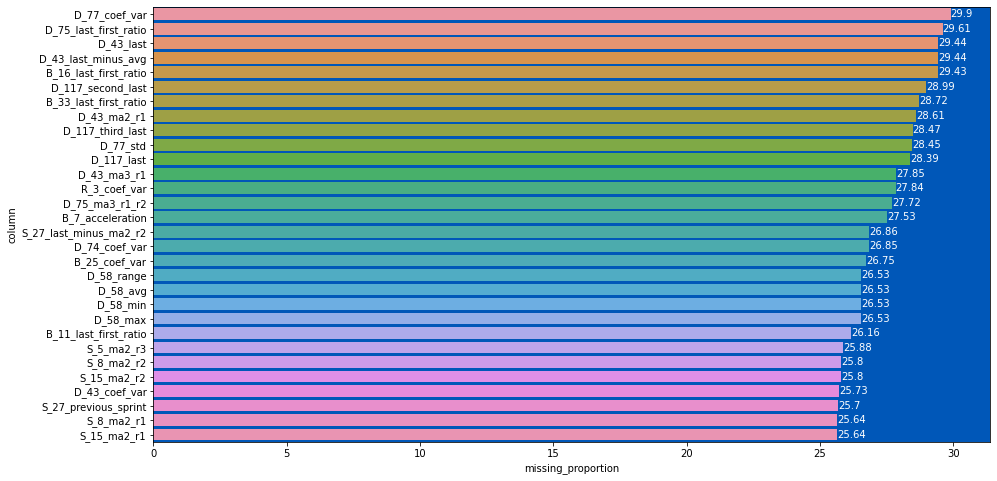

In [103]:
m = plot_missing_proportion_barchart(test_agg)

In [84]:
for col in tqdm(m["column"].tolist()):
    train_agg[col] = train_agg[col].fillna(train_agg[col].mean())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2118/2118 [33:54<00:00,  1.04it/s]


In [104]:
for col in tqdm(m["column"].tolist()):
    test_agg[col] = test_agg[col].fillna(test_agg[col].mean())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2184/2184 [1:40:34<00:00,  2.76s/it]


In [85]:
# Save a copy out to prevent reproduce
train_agg.to_parquet("./interim_train_agg_imputed.parquet")

In [113]:
# Save a copy out to prevent reproduce
test_agg.to_parquet("./interim_test_agg_imputed.parquet")

In [5]:
%%time
test_agg = read_file("./interim_test_agg_imputed.parquet")

Shape of data: (924621, 2852)
CPU times: user 11.8 s, sys: 21.9 s, total: 33.7 s
Wall time: 24.8 s


### Standardized

In [90]:
sscaler = StandardScaler()

In [91]:
train_agg_ = sscaler.fit_transform(train_agg)

In [92]:
train_agg_.shape

(458913, 2852)

In [94]:
train_agg_df = pd.DataFrame(train_agg_, columns=train_agg.columns)

In [96]:
train_agg_df.to_parquet("./interim_train_agg_imputed_standardized.parquet")

In [ ]:
del train_agg, train_agg_, train_agg_df

In [6]:
sscaler = StandardScaler()

In [7]:
test_agg_df = pd.DataFrame(sscaler.fit_transform(test_agg), columns=test_agg.columns) 

In [8]:
test_agg_df.to_parquet("./interim_test_agg_imputed_standardized.parquet")

In [20]:
del test_agg_df

### Train Regression Model

In [9]:
from sklearn.linear_model import ElasticNet, RANSACRegressor

In [19]:
%%time
train_agg_df = read_file("./interim_train_agg_imputed_standardized.parquet")

Shape of data: (458913, 2853)


In [ ]:
ransac = RANSACRegressor(
    ElasticNet(),
    max_trials=5, 		# Number of Iterations
	min_samples=200, 		# Minimum size of the sample
	loss='absolute_loss', 	# Metrics for loss
	residual_threshold=1 	# Threshold
)

#### Prepare ground truth (residual)

In [10]:
residuals_df = read_file(f"./residual.csv")

Shape of data: (458913, 3)


In [11]:
residuals_df["stacked_oof_raw_score"] = residuals_df["stacked_oof_score"].apply(reverse_sigmoid)

In [12]:
residuals_df.describe()

,target,stacked_oof_score,stacked_oof_raw_score
count,458913.000000,458913.000000,458913.000000
mean,0.258934,0.258932,-2.891598
std,0.438050,0.355058,3.700827
min,0.000000,0.000040,-10.138762
25%,0.000000,0.002349,-6.051260
50%,0.000000,0.025026,-3.662511
75%,1.000000,0.524904,0.099697
max,1.000000,0.999952,9.946160


In [13]:
zero = residuals_df.loc[residuals_df["target"] == 0]
residuals_df.loc[residuals_df["target"] == 0, "residuals"] = zero["stacked_oof_raw_score"].min() - zero["stacked_oof_raw_score"]

In [14]:
one = residuals_df.loc[residuals_df["target"] == 1]
residuals_df.loc[residuals_df["target"] == 1, "residuals"] = one["stacked_oof_raw_score"].max() - one["stacked_oof_raw_score"]

In [15]:
target = residuals_df["residuals"]

In [16]:
target.describe()

count    458913.000000
mean         -2.046503
std           6.507298
min         -16.315276
25%          -6.387726
50%          -4.022097
75%           3.774381
max          18.352239
Name: residuals, dtype: float64

In [26]:
kfold = KFold(n_splits=5, shuffle=True, random_state=8)

In [63]:
models = []
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train_agg_df, target)):
    x_train, x_val = train_agg_df.iloc[trn_ind], train_agg_df.iloc[val_ind]
    y_train, y_val = target[trn_ind], target[val_ind]
    binary_target = residuals_df.iloc[val_ind]["target"]
    model = ElasticNet(alpha=0.5, l1_ratio=0.4, selection="random")
    model.fit(x_train, y_train)
    y_val_pred = model.predict(x_val)
    print(f"Fold {fold},", f"MSE: {np.sqrt(mean_squared_error(y_val, y_val_pred))}")
    residuals_df.loc[val_ind, "oof_score"] = y_val_pred
    models.append(model)

Fold 0, MSE: 5.669921952804548
Fold 1, MSE: 5.685462328770041
Fold 2, MSE: 5.687940022314872
Fold 3, MSE: 5.705265138458218
Fold 4, MSE: 5.696761861066573


In [64]:
models2 = []
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train_agg_df, target)):
    x_train, x_val = train_agg_df.iloc[trn_ind], train_agg_df.iloc[val_ind]
    y_train, y_val = target[trn_ind], target[val_ind]
    # binary_target = residuals_df.iloc[val_ind]["target"]
    model = ElasticNet(alpha=0.4, l1_ratio=0.3, selection="random")
    model.fit(x_train, y_train)
    y_val_pred = model.predict(x_val)
    print(f"Fold {fold},", f"MSE: {np.sqrt(mean_squared_error(y_val, y_val_pred))}")
    residuals_df.loc[val_ind, "oof_score2"] = y_val_pred
    models2.append(model)

Fold 0, MSE: 5.631167207370982
Fold 1, MSE: 5.649314114216058
Fold 2, MSE: 5.6514652050092415
Fold 3, MSE: 5.668793907720221
Fold 4, MSE: 5.659582874508525


In [67]:
residuals_df.to_csv(f"./experiment_result.csv", index=False)

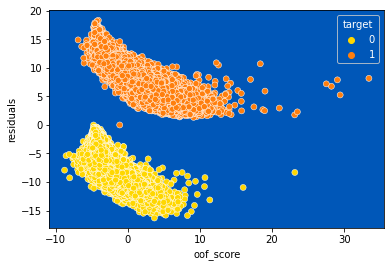

In [65]:
sns.scatterplot(residuals_df["oof_score"], residuals_df["residuals"], hue=residuals_df["target"])
plt.show()

In [24]:
for fold, (trn_ind, val_ind) in enumerate(kfold.split(train_agg, target)):
    print(' ')
    print('-'*50)
    print(f'Training fold {fold} with {train_agg.shape[1]} features...')
    print('-'*50)
    x_train, x_val = train_agg.iloc[trn_ind], train_agg.iloc[val_ind]
    y_train, y_val = target[trn_ind], target[val_ind]
    lgb_train = lgb.Dataset(x_train, y_train, categorical_feature=cat_features)
    lgb_valid = lgb.Dataset(x_val, y_val, categorical_feature=cat_features)
    model = lgb.train(
        params = params,
        train_set = lgb_train,
        num_boost_round = 6000,
        valid_sets = [lgb_train, lgb_valid],
        early_stopping_rounds = 300,
        verbose_eval = 500,
        feval = lgb_amex_metric
    )
    # Save best model
    joblib.dump(model, f'./models/model_fold{fold}_seed{seed}.pkl')
    # Predict validation
    y_val_pred = model.predict(x_val, raw_score=True)
    # # Add to out of folds array
    # oof_predictions[val_ind] = val_pred
    # Predict the test set
    # test_pred = model.predict(test[features])
    # test_predictions += test_pred / CFG.n_folds
    # Compute fold metric
    val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)                                      
    print(f'Our fold {fold} CV score is {val_score}')
    del x_train, x_val, y_train, y_val, lgb_train, lgb_valid
    gc.collect()

 
--------------------------------------------------
Training fold 0 with 2273 features...
--------------------------------------------------
[LightGBM] [Info] Number of positive: 95062, number of negative: 272068
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.267381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 484494
[LightGBM] [Info] Number of data points in the train set: 367130, number of used features: 2273
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258933 -> initscore=-1.051523
[LightGBM] [Info] Start training from score -1.051523
[500]	training's binary_logloss: 0.247401	training's amex: 0.784738	valid_1's binary_logloss: 0.256278	valid_1's amex: 0.771125
[1000]	training's binary_logloss: 0.219938	training's amex: 0.804609	valid_1's binary_logloss: 0.23433	valid_1's amex: 0.781003
[1500]	training's binary_logloss: 0

Exception ignored in: <function Booster.__del__ at 0x14f9de170>
Traceback (most recent call last):
  File "/Users/wklee/miniconda3/envs/amex/lib/python3.10/site-packages/lightgbm/basic.py", line 2664, in __del__
    _safe_call(_LIB.LGBM_BoosterFree(self.handle))
KeyboardInterrupt: 

KeyboardInterrupt

